# **Task 3: Customer Segmentation / Clustering**



---



### Import Required Libraries

In [24]:
#Import all the required libraries

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler




---



### Load the Datasets

In [25]:
# Load datasets

customers = pd.read_csv("/content/drive/MyDrive/ZEOTAP/Customers.csv")
transactions = pd.read_csv("/content/drive/MyDrive/ZEOTAP/Transactions.csv")




---



### Data Preprocessing

In [26]:
# Merge datasets
data = pd.merge(customers, transactions, on="CustomerID")

# Aggregate transaction data
agg_data = data.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "TransactionID": "count",
    "TransactionDate": lambda x: (pd.Timestamp("2025-01-01") - pd.to_datetime(x)).dt.days.mean(),
}).rename(columns={"TransactionID": "TransactionCount", "TransactionDate": "AvgRecency"}).reset_index()

# Merge with profile data
final_data = pd.merge(customers, agg_data, on="CustomerID")

# Encode categorical data
final_data["Region"] = final_data["Region"].astype("category").cat.codes

# Feature selection
features = final_data[["TotalValue", "TransactionCount", "AvgRecency", "Region"]]

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)




---



### Clustering using DBSCAN Algorithm

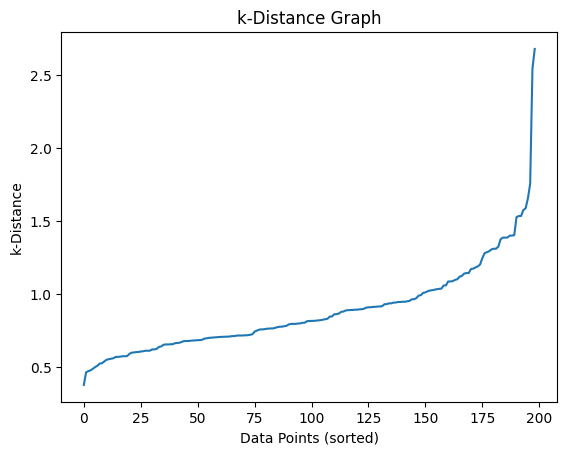

In [27]:
# Function to find optimal epsilon for DBSCAN

def optimal_eps(data, k=5):
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    neighbors = nearest_neighbors.fit(data)
    distances, _ = neighbors.kneighbors(data)
    distances = np.sort(distances[:, k-1], axis=0)
    return distances

# Plot k-distance graph to find the elbow point
distances = optimal_eps(scaled_features)
plt.plot(distances)
plt.title("k-Distance Graph")
plt.xlabel("Data Points (sorted)")
plt.ylabel("k-Distance")
plt.show()

# Select epsilon based on the elbow point.
eps = 0.5

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=5)
labels = dbscan.fit_predict(scaled_features)

# Add cluster labels to the data
final_data["Cluster"] = labels



---



### Visualizing Clusters

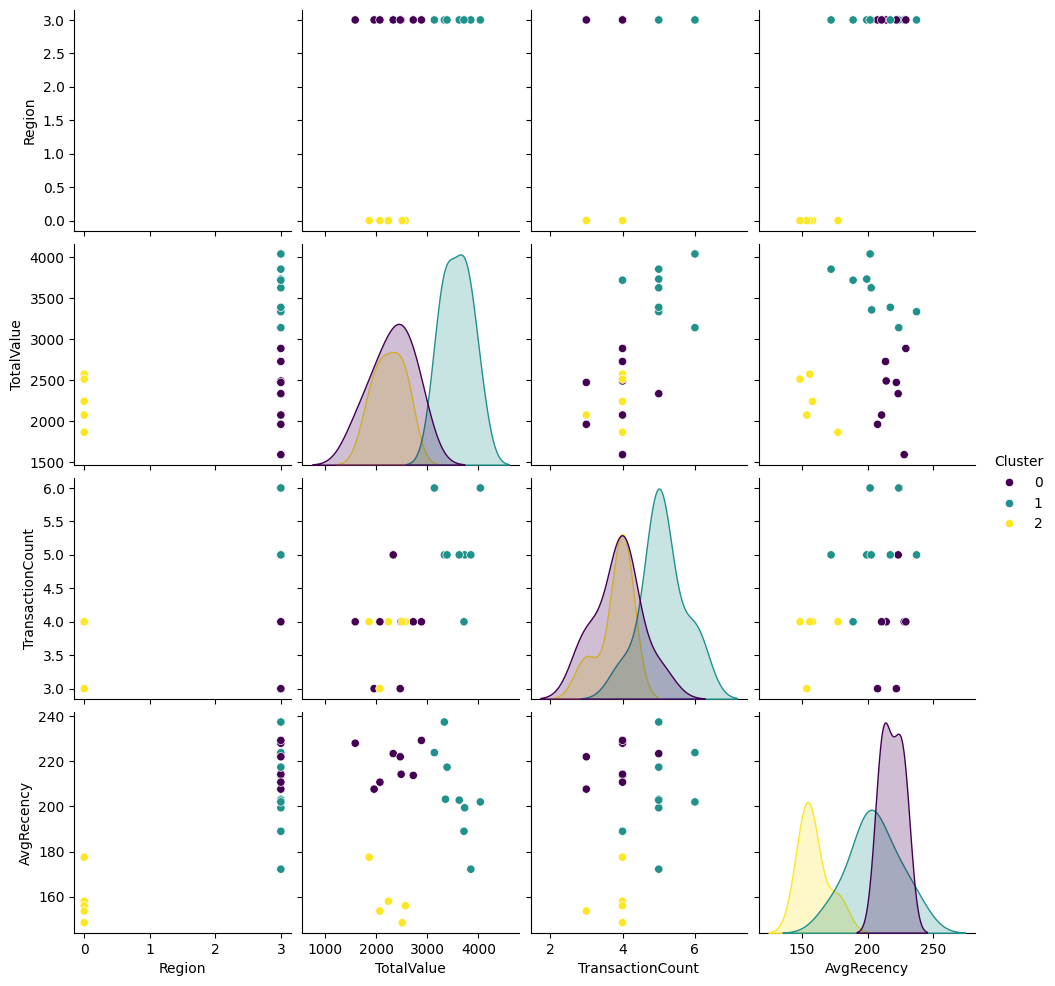

In [28]:
# Cluster Visualization

sns.pairplot(final_data[final_data["Cluster"] != -1], hue="Cluster", diag_kind="kde", palette="viridis")
plt.show()


In [35]:
num_clusters = len(np.unique(labels[labels != -1]))
print("------------------------------------------------")
print(f"Number of clusters formed: {num_clusters}")
print("------------------------------------------------")

------------------------------------------------
Number of clusters formed: 3
------------------------------------------------




---



### Evaluating Clustering Performance

In [30]:
# Evaluate clustering performance

valid_clusters = labels[labels != -1]
if len(np.unique(valid_clusters)) > 1:
    dbi = davies_bouldin_score(scaled_features[labels != -1], valid_clusters)
    silhouette = silhouette_score(scaled_features[labels != -1], valid_clusters)
else:
    dbi = np.inf
    silhouette = -1

print("Clustering Performance Metrics:")
print("---------------------------------------")
print(f"DBI Value: {dbi}")
print("---------------------------------------")
print(f"Silhouette Score: {silhouette}")
print("---------------------------------------")

Clustering Performance Metrics:
---------------------------------------
DBI Value: 0.6074125439555892
---------------------------------------
Silhouette Score: 0.5326339907001608
---------------------------------------


**The DB Index value of the clustering is close to zero (0.607), indicating that the clustering can be regarded as efficient. A total of three clusters were formed.**



---



### Clustering Summary

In [20]:
cluster_summary = valid_clusters.groupby("Cluster").agg({
    "TotalValue": ["mean", "min", "max"],
    "TransactionCount": ["mean", "min", "max"],
    "AvgRecency": ["mean", "min", "max"],
    "Region": "mean"
}).reset_index()

Cluster_summary = cluster_summary.style.format({
    'TotalValue mean': '${:,.2f}',
    'TotalValue min': '${:,.2f}',
    'TotalValue max': '${:,.2f}',
    'TransactionCount mean': '{:.2f}',
    'TransactionCount min': '{:.2f}',
    'TransactionCount max': '{:.2f}',
    'AvgRecency mean': '{:.2f}',
    'AvgRecency min': '{:.2f}',
    'AvgRecency max': '{:.2f}',
    'Region mean': '{:.2f}'
}).background_gradient(axis=None, cmap='YlGnBu')

Cluster_summary


### **Cluster 0: Moderate-Value Customers**
- **Average TotalValue**: $2,315.36 (moderate spending).
- **Transaction Count**: Average of 3.87 transactions, with a range of 3–5.
- **AvgRecency**: Average of 218.63 days, indicating older transactions.
- **Region**: Predominantly from Region 3.
- **Insight**:
  - Customers with moderate spending and older transactions.  
  - **Suggested Action**: Re-engagement strategies or targeted promotions to encourage repeat purchases.




### **Cluster 1: High-Value, Frequent Buyers**
- **Average TotalValue**: $3,574.25 (highest among clusters).
- **Transaction Count**: Highest frequency with an average of 5.11 transactions, ranging from 4–6.
- **AvgRecency**: Average of 205.25 days, with some more recent activity (minimum of 172 days).
- **Region**: Predominantly from Region 3.
- **Insight**:
  - These are your **VIP customers** who spend the most and buy frequently.  
  - **Suggested Action**: Focus on loyalty programs, exclusive offers, and personalized services to retain them.




### **Cluster 2: Low-Value Recent Buyers**
- **Average TotalValue**: $2,250.96 (lowest spending cluster).
- **Transaction Count**: Average of 3.8 transactions, ranging from 3–4.
- **AvgRecency**: Average of 158.73 days, indicating the most recent purchases.
- **Region**: Predominantly from Region 0.
- **Insight**:
  - These customers are newer or less active buyers but have more recent transactions.  
  - **Suggested Action**: Upselling campaigns or targeted promotions to increase their spending.




## **Key Takeaways**
1. **Cluster 1 (High-Value, Frequent Buyers)**:
   - Should be the primary focus for retention and rewards, as they contribute the most value.
2. **Cluster 0 (Moderate-Value Customers)**:
   - Requires reactivation strategies to boost engagement and spending.
3. **Cluster 2 (Low-Value Recent Buyers)**:
   - Represents potential for growth through upselling and targeted engagement initiatives.




---

